# 딥러닝의 기본 이미지 분류하기
## Chapter 1 손글씨 숫자 분류와 CNN

### 1.5 학습 준비

In [1]:
import random

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np

import matplotlib.pyplot as plt

In [ ]:
is_cuda = torch.cuda.is_available()   # GPU가 사용가능한지
device = torch.device("cuda" if is_cuda else "cpu") # GPU가 사용가능하다면 GPU를 사용 아니면 CPU 사용
print(is_cuda, device)

In [3]:
seed = 1010
random.seed(seed)         # python seed
np.random.seed(seed)      # numpy seed
torch.manual_seed(seed)   # torch seed
if device == 'cuda':
  torch.cuda.manual_seed_all(seed)  # gpu seed

### 1.6 MNIST 데이터셋

In [4]:
from torch.utils.data import random_split


def get_mnist_dataloaders(batch_size, val=0.2, num_workers=0):
  transform = transforms.Compose([
    transforms.ToTensor(),
  ])

  # split
  mnist_train_origin = datasets.MNIST(
      root='MNIST/',
      train=True,
      download=True,
      transform=transform,
  )
  val_samples = int(len(mnist_train_origin) * val)
  train_samples = len(mnist_train_origin) - val_samples

  # dataset
  mnist_train, mnist_val = random_split(
      mnist_train_origin,
       (train_samples, val_samples),
  )
  mnist_test = datasets.MNIST(
      root='MNIST/',
      train=False,
      download=True,
      transform=transform,
  )

  # dataloader
  train_loader = DataLoader(
      dataset=mnist_train,
      batch_size=batch_size,
      drop_last=True,
      shuffle=True,
      num_workers=num_workers,
  )
  val_loader = DataLoader(
      dataset=mnist_val,
      batch_size=batch_size,
      num_workers=num_workers,
  )
  test_loader = DataLoader(
      dataset=mnist_test,
      batch_size=batch_size,
      num_workers=num_workers,
  )

  return train_loader, val_loader, test_loader

### 1.7 LeNet

In [5]:
class LeNet(nn.Module):
  def __init__(self):
    super(LeNet, self).__init__()
    self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
    self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
    self.pool = nn.MaxPool2d(2, 2)
    self.fc1 = nn.Linear(16 * 4 * 4, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.relu(self.conv1(x))
    x = self.pool(x)
    x = self.relu(self.conv2(x))
    x = self.pool(x)
    x = x.view(x.size(0), -1)
    x = self.relu(self.fc1(x))
    x = self.relu(self.fc2(x))
    x = self.fc3(x)
    return x

### 1.8 학습, 검증, 테스트

In [6]:
def train(model, dataloader, criterion, optimizer, epoch):
  # train mode
  model.train()

  # 학습 통계
  running_loss = 0
  correct = 0

  for i, (data, targets) in enumerate(dataloader):
    data.to(device), targets.to(device)   # data device로 이동

    optimizer.zero_grad()       # gradient 초기화
    outputs = model(data)       # forward
    loss = criterion(outputs, targets)    # loss 계산
    loss.backward()             # gradient 계산
    optimizer.step()            # weight update

    running_loss += loss.item()

    # Accuracy 계산
    _, predicted = torch.max(outputs, 1)
    correct += predicted.eq(targets.view_as(predicted)).sum()

  # Accuracy 출력
  data_num = len(dataloader.dataset)
  acc = 100. * correct / data_num
  print(
      f"[{epoch}/{EPOCH}]",
      f"train loss: {running_loss/len(dataloader):.4f}",
      f"train acc: {correct}/{data_num} ({acc:.2f}%)"
  )

  return running_loss/len(dataloader)

In [7]:
def validation(model, dataloader, criterion, epoch):
  # eval 모드
  model.eval()

  # 검증 통계
  correct = 0
  running_loss = 0.

  with torch.no_grad():   # gradient 계산 안하기
    for i, (data, targets) in enumerate(dataloader):
      data.to(device), targets.to(device)   # data device로 이동

      outputs = model(data)               # forward
      loss = criterion(outputs, targets)  # loss 계산

      running_loss += loss.item()

      # Accuracy 계산
      _, predicted = torch.max(outputs, 1)
      correct += predicted.eq(targets.view_as(predicted)).sum()

  # Accuracy 계산
  data_num = len(dataloader.dataset)
  acc = 100. * correct / data_num
  print(f'[{epoch}/{EPOCH}] valid loss: {running_loss/len(dataloader):.4f} valid acc: {correct}/{data_num} ({acc:.2f}%)\n')

  return running_loss/len(dataloader)

In [8]:
def test(model, dataloader):
  # eval 모드
  model.eval()

  # 테스트 통계
  correct = 0

  with torch.no_grad():
    for data, targets in dataloader:
      data.to(device), targets.to(device)

      outputs = model(data)    # forward

      # Accuracy 계산
      _, predicted = torch.max(outputs, 1)
      correct += predicted.eq(targets.view_as(predicted)).sum()

  # Accuracy 계산
  data_num = len(dataloader.dataset)
  print(f'Test Accuracy: {correct}/{data_num} ({100. * correct / data_num:.2f}%)')

In [9]:
# Hyperparameters
# Training
EPOCH = 5
BATCH_SIZE = 32
NUM_WORKERS = 1
LR = 0.001

# Model
model = LeNet()
print(model)

# MNIST dataloader
train_loader, val_loader, test_loader = \
get_mnist_dataloaders(BATCH_SIZE, val=0.2, num_workers=NUM_WORKERS)

# Loss, Optimizer 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

train_losses = []
val_losses = []

for epoch in range(EPOCH):
  tloss = train(model, train_loader, criterion, optimizer, epoch)
  vloss = validation(model, val_loader, criterion, epoch)

  train_losses.append(tloss)
  val_losses.append(vloss)

test(model, test_loader)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (relu): ReLU()
)


100.0%
100.0%
100.0%
100.0%


[0/5] train loss: 0.2647 train acc: 43929/48000 (91.52%)
[0/5] valid loss: 0.1105 valid acc: 11582/12000 (96.52%)

[1/5] train loss: 0.0869 train acc: 46676/48000 (97.24%)
[1/5] valid loss: 0.0658 valid acc: 11749/12000 (97.91%)

[2/5] train loss: 0.0603 train acc: 47073/48000 (98.07%)
[2/5] valid loss: 0.0572 valid acc: 11792/12000 (98.27%)

[3/5] train loss: 0.0491 train acc: 47253/48000 (98.44%)
[3/5] valid loss: 0.0482 valid acc: 11837/12000 (98.64%)

[4/5] train loss: 0.0394 train acc: 47385/48000 (98.72%)
[4/5] valid loss: 0.0433 valid acc: 11852/12000 (98.77%)

Test Accuracy: 9889/10000 (98.89%)


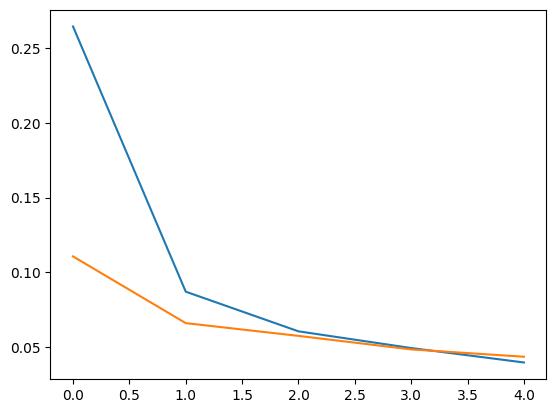

In [10]:
import matplotlib.pyplot as plt

plt.plot(train_losses)
plt.plot(val_losses)